In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage import filters
from skimage import morphology
import math
from skimage import measure
import time
import sklearn.preprocessing
from sklearn.ensemble import RandomForestClassifier

In [3]:
#Wczytywanie obrazków, image w 2 wariantach - czarno białym i kolorowym
dt=[('0' if x<10 else '')+str(x) for x in range(1, 15)]
dy=[[y+'_'+x for y in dt] for x in ['dr', 'h', 'g']]
z=[]
for x in dy:
    z=z+x
print(z)

flag=cv2.IMREAD_GRAYSCALE
#flag=cv2.IMREAD_COLOR
Manuals = [cv2.imread(f"manual1/{x}.tif", flag) for x in z]
Masks= [cv2.imread(f"mask/{x}_mask.tif", flag) for x in z]
Images= [cv2.imread(f"images/{x}.jpg", flag) for x in z]

zupaImagez=[cv2.imread(f"images/{x}.jpg", cv2.IMREAD_COLOR) for x in z]

Creation=[list(w) for w in zip(Manuals, Masks, Images, zupaImagez)]

['01_dr', '02_dr', '03_dr', '04_dr', '05_dr', '06_dr', '07_dr', '08_dr', '09_dr', '10_dr', '11_dr', '12_dr', '13_dr', '14_dr', '01_h', '02_h', '03_h', '04_h', '05_h', '06_h', '07_h', '08_h', '09_h', '10_h', '11_h', '12_h', '13_h', '14_h', '01_g', '02_g', '03_g', '04_g', '05_g', '06_g', '07_g', '08_g', '09_g', '10_g', '11_g', '12_g', '13_g', '14_g']


In [4]:
#Normalizacja - Otrzymane wyniki będą nieznormalizowane przy pominięciu tej komórki
#W pokazywanych w sprawozdaniu rezultatach nie zaszła normalizacja
blurk=np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
blurk2=np.asarray([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])/256

res=[]
for i, x in enumerate(Creation[:20]):
    sv=x[3]
    
    #####  NORMALIZACJA  #####
    mx, mn=max(sv[sv>-1]), min(sv[sv>-1])
    sv=(sv-mn)/(mx-mn)
    sv[:,:,0]=np.multiply(sv[:,:,0], x[1]/255)
    sv[:,:,1]=np.multiply(sv[:,:,1], x[1]/255)
    sv[:,:,2]=np.multiply(sv[:,:,2], x[1]/255)
    sv=np.asarray(sv*255, dtype='uint8')
    
    #####  DENOISING  #####
    raka=sv
    raka=np.asarray(raka, dtype='uint8')
    raka=cv2.fastNlMeansDenoising(raka)
    
    #####  BLURRING  #####
    dt=raka
    dt[:,:,0]=np.absolute(signal.convolve2d(raka[:,:,0], blurk2, mode='same'))
    dt[:,:,1]=np.absolute(signal.convolve2d(raka[:,:,1], blurk2, mode='same'))
    dt[:,:,2]=np.absolute(signal.convolve2d(raka[:,:,2], blurk2, mode='same'))
    dt[dt>255]=255
    for i in range(10): 
        dt[:,:,0]=np.absolute(signal.convolve2d(dt[:,:,0], blurk2, mode='same'))
        dt[:,:,1]=np.absolute(signal.convolve2d(dt[:,:,1], blurk2, mode='same'))
        dt[:,:,2]=np.absolute(signal.convolve2d(dt[:,:,2], blurk2, mode='same'))
        dt[dt>255]=255
    
    #Rezultat - używany w następnych fazach algorytmu
    Creation[i][3]=dt

In [6]:
#Dodanie paddingu do obrazka
def pad(img, con=3):
    if (len(img.shape)==2):
        dt=np.zeros((img.shape[0]+2*con, img.shape[1]+2*con), dtype='uint8')
        dt[con:dt.shape[0]-con,con:dt.shape[1]-con]=img
    else:
        dt=np.zeros((img.shape[0]+2*con, img.shape[1]+2*con, img.shape[2]), dtype='uint8')
        dt[con:dt.shape[0]-con,con:dt.shape[1]-con]=img
    
    return dt

#Informacje o części obrazka
def getItem(img, x, y, mask, con=3, img2=None):
    if (img2 is None):
        mcen=measure.moments_central(img[x-con:x+con,y-con:y+con])
        vz=[img[x-con:x+con,y-con:y+con].var()]
    else:
        mcen=measure.moments_central(img2[x-con:x+con,y-con:y+con])
        vz=[img2[x-con:x+con,y-con:y+con,z].var() for z in range(3)]
    col=[img[x,y]]
    maske=[np.all(mask[x-con:x+con,y-con:y+con])]
    lees=np.concatenate((vz, col, np.reshape(mcen, mcen.shape[0]*mcen.shape[1]*mcen.shape[2]), maske))
    return lees

#Wzięcie odpowiedzi dla punktów wymienionych w tuplu
def getImagoRandomoRes(resimg, tupls):
    res=[]
    for x in tupls:
        res.append(resimg[x[0], x[1]])
    return np.asarray(res)

#Wybór losowych danych, szerzej opisany w sprawozdaniu; 0 - manual, 1 - maska, 2 - oryginał
def randomizer(set_img, Z=200001, signify=0):
    Cnt=5
    img2=pad(set_img[2], Cnt)
    img3=pad(set_img[3], Cnt)
    maska=pad(set_img[1], Cnt)
    dissolve=[]
    tuplez=[]
    setall=set()
    
    for i in range(Z):
        while (True):
            rn=np.random.randint(0, set_img[0].shape[0]*set_img[0].shape[1])
            rny=rn%set_img[1].shape[1]
            rnx=rn//set_img[1].shape[1]
            
            if (signify==0 and 
                set_img[1][rnx,rny]!=0 and
                (set_img[0][rnx,rny]!=0 or
                 np.random.randint(0, 4)%4==0) and
               {(rnx, rny)} not in setall):
                break
            elif (signify==1 and 
                set_img[1][rnx,rny]!=0 and
               {(rnx, rny)} not in setall):
                break
        dissolve.append(getItem(img2, rnx+Cnt, rny+Cnt, maska, Cnt, img3))
        setall|={(rnx, rny)}
        tuplez.append((rnx, rny))
        #print(rnx, rny, set_img[0][rnx,rny])
    return np.asarray(dissolve), tuplez

#Preprocessing danych
def preproc(data):
    dv=sklearn.preprocessing.normalize(data)
    return dv

#Ewaluacja heurystyki
def evaluator(im1, im2):
    dicc={}
    dicc["1st B"]=len(im1[im1==0])
    dicc["1st W"]=len(im1[im1!=0])
    dicc["2nd B"]=len(im2[im2==0])
    dicc["2nd W"]=len(im2[im2!=0])
    
    dicc["tp"]=len(im2[(im2==im1) & (im2!=0)])
    dicc["tn"]=len(im2[(im2==im1) & (im2==0)])
    dicc["fp"]=len(im2[(im2!=im1) & (im2!=0)])
    dicc["fn"]=len(im2[(im2!=im1) & (im2==0)])
    _=[print(x, dicc[x]) for x in ["tp", "tn", "fp", "fn"]]
    if (dicc["fn"]==0):
        dicc["fn"]=1
    
    dicc["acc"]=(dicc["tp"]+dicc["tn"])/(dicc["tp"]+dicc["tn"]+dicc["fp"]+dicc["fn"])
    dicc["prec"]=dicc["tp"]/(dicc["tp"]+dicc["fp"])
    dicc["rec"]=dicc["tp"]/(dicc["tp"]+dicc["fn"])
    
    return dicc

In [7]:
x1=[]
y1=[]
#Wyznaczenie trainseta i wyniku tego seta
for i in [0, 7, 11]:
    xv, locsv=randomizer(Creation[i], signify=1)
    yv=getImagoRandomoRes(Creation[i][0], locsv)
    x1=x1+list(xv)
    y1=y1+list(yv)
    print(i)
x1=np.asarray(x1)
y1=np.asarray(y1)
    
##Normalizacja trainseta, uwypuklenie kluczowych cech
xp1=preproc(x1)

0
7
11


In [24]:
#Podział na grupy - wyznaczenie tablicy do k-cross validation
KValid=4

def f(x, l, val):
    s=l//val
    return x//s

Gr=[f(x, len(x1)+1, KValid) for x in range(len(x1))]
np.random.shuffle(Gr)
Gr=np.asarray(Gr)

In [25]:
#Funkcja zwraca średnią rezultatów użycia 4 drzew dla różnych grup
def validato(ter, Gr, KV, x, y):
    summa=0
    for numb in range(KV):
        rfc1=RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=ter)
        rfc1.fit(x[Gr!=numb], y[Gr!=numb])
        ypt=rfc1.predict(x[Gr==numb])
        dct=evaluator(y[Gr==numb], ypt)
        summa+=math.sqrt(dct['prec']*dct['rec'])
    return summa/KV

#Ternary search optymalnego max_depth z ograniczeniem (żeby nie zajmował za dużo czasu - i tak trwa prawie godzinę)
l, r=0, len(x1)
while (r-l>500):
    a=l+(r-l)//3
    b=l+2*(r-l)//3
    
    curres1=validato(a, Gr, KValid, xp1, y1)
    curres2=validato(b, Gr, KValid, xp1, y1)
    if (curres1<curres2):
        l=a
    elif (curres1>curres2):
        r=b
    else:
        l, r=a, b
    
    print(l, r, curres1, curres2)

tp 5073
tn 21468
fp 1054
fn 2406
tp 5050
tn 21429
fp 1050
fn 2472
tp 5007
tn 21587
fp 1030
fn 2377
tp 5024
tn 21496
fp 1084
fn 2396
tp 5053
tn 21469
fp 1053
fn 2426
tp 5027
tn 21453
fp 1026
fn 2495
tp 5003
tn 21577
fp 1040
fn 2381
tp 5027
tn 21498
fp 1082
fn 2393
0 80002 0.7477836950384165 0.7470890744834737
tp 5048
tn 21461
fp 1061
fn 2431
tp 5065
tn 21451
fp 1028
fn 2457
tp 4989
tn 21575
fp 1042
fn 2395
tp 4994
tn 21524
fp 1056
fn 2426
tp 5063
tn 21511
fp 1011
fn 2416
tp 5049
tn 21431
fp 1048
fn 2473
tp 5009
tn 21551
fp 1066
fn 2375
tp 5022
tn 21476
fp 1104
fn 2398
26667 80002 0.7469874977010493 0.7473762312606447
tp 5088
tn 21452
fp 1070
fn 2391
tp 5052
tn 21440
fp 1039
fn 2470
tp 5007
tn 21558
fp 1059
fn 2377
tp 5011
tn 21541
fp 1039
fn 2409
tp 5099
tn 21487
fp 1035
fn 2380
tp 5055
tn 21458
fp 1021
fn 2467
tp 5068
tn 21545
fp 1072
fn 2316
tp 5026
tn 21489
fp 1091
fn 2394
44445 80002 0.7480340142411305 0.7498116451778263
tp 5040
tn 21484
fp 1038
fn 2439
tp 5046
tn 21426
fp 1053
fn 2

In [8]:
#Tworzenie klasyfikatora z całymi danymi - l wpisane z poprzedniej operacji, żeby nie kalkulować
# tej wartości za każdym użyciem notebooka - to trwa ok. godziny
l=65921
rfc=RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=l)
rfc.fit(xp1, y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=65921, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [9]:
#Wyznaczanie wyniku dla zrandomizowanych podzbiorów poszczególnych obrazków
ln, sgeom=20, 0
allres=[]
for i in range(0, ln):
    t1=time.time()
    
    xt, locst=randomizer(Creation[i], signify=1)
    yt=getImagoRandomoRes(Creation[i][0], locst)
    xpt=preproc(xt)
    ypt=rfc.predict(xpt)
    print()
    print(f"Obraz {i+1}:")
    dct=evaluator(yt, ypt)
    print(f"acc:{dct['acc']}, prec:{dct['prec']}, rec:{dct['rec']}, geom:{math.sqrt(dct['prec']*dct['rec'])}")
    
    t2=time.time()
    print(t2-t1)
    print()
    sgeom=sgeom+math.sqrt(dct['prec']*dct['rec'])
    dct['sgeom']=math.sqrt(dct['prec']*dct['rec'])
    dct['title']=f'RFC-{z[i]}'
    allres.append(dct)
print(f"result: {sgeom/ln}")


Obraz 1:
tp 6065
tn 186459
fp 1565
fn 5912
acc:0.9626151869240653, prec:0.7948885976408913, rec:0.5063872422142439, geom:0.6344457776886206
44.50009298324585


Obraz 2:
tp 6029
tn 182403
fp 2488
fn 9081
acc:0.9421552892235538, prec:0.7078783609252084, rec:0.3990072799470549, geom:0.5314589535666391
45.014389514923096


Obraz 3:
tp 6949
tn 182733
fp 2998
fn 7321
acc:0.9484052579737101, prec:0.6986025937468584, rec:0.4869656622284513, geom:0.5832627835705383
45.89769506454468


Obraz 4:
tp 3733
tn 184581
fp 2062
fn 9625
acc:0.9415652921735391, prec:0.6441760138050043, rec:0.2794580026950142, geom:0.4242878058605767
45.2902410030365


Obraz 5:
tp 12937
tn 79866
fp 105503
fn 1695
acc:0.46401267993660034, prec:0.10922830124957784, rec:0.8841580098414434, geom:0.31076530927886464
44.24892234802246


Obraz 6:
tp 15050
tn 96361
fp 85655
fn 2935
acc:0.5570522147389263, prec:0.14944640285983815, rec:0.8368084514873506, geom:0.35363542378768553
44.667502641677856


Obraz 7:
tp 7109
tn 178438
fp 

In [55]:
#Rysowanie efektów predykcji części obrazka, część 1. - zdobycie danych
c0=500
c1=1000
Im=1
dissolve=[]
Cnt=5

t1=time.time()
img2=pad(Creation[Im][2], Cnt)
img3=pad(Creation[Im][3], Cnt)
maska=pad(Creation[Im][1], Cnt)
for i in range(c0, c0+c1):
    for j in range(c0, c0+c1):
        dissolve.append(getItem(img2, i+Cnt, j+Cnt, maska, Cnt, img3))

t2=time.time()
print(t2-t1)

166.7324197292328


In [56]:
#Wyznaczenie predykcji dla części obrazka
t1=time.time()
dt=np.zeros((c1, c1), dtype='float64')
xv=preproc(dissolve)
ypt=rfc.predict(np.asarray(xv))

ij=0
for i in range(c0, c0+c1):
    for j in range(c0, c0+c1):
        dt[i-c0,j-c0]=ypt[ij]
        ij+=1

t2=time.time()
print(t2-t1)

8.204624891281128


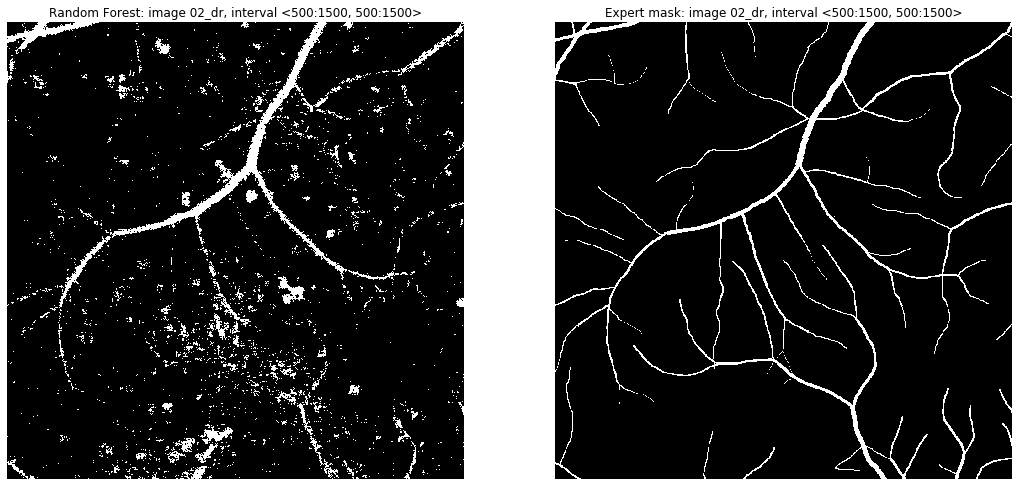

In [65]:
#Obraz efektów pracy klasyfikatora
fig, ax=plt.subplots(1, 2, figsize=(18,18))
ax[1].imshow(Creation[Im][0][c0:c0+c1,c0:c0+c1], cmap='gray')
ax[0].imshow(dt, cmap='gray')
ax[0].set_title(f"Random Forest: image {z[Im]}, interval <{c0}:{c0+c1}, {c0}:{c0+c1}>")
ax[1].set_title(f"Expert mask: image {z[Im]}, interval <{c0}:{c0+c1}, {c0}:{c0+c1}>")
ax[1].set_axis_off()
ax[0].set_axis_off()
plt.show() 

In [10]:
#Dane częściowe klasyfikatora
allez={}
for x in allres:
    print(f"{x['title']} & {x['tp']} & {x['tn']} & {x['fn']} & {x['fp']} & {x['acc']:.4f} & {x['prec']:.4f} & {x['rec']:.4f} & {x['sgeom']:.4f} \\\\ \hline")
    for y in x:
          if y not in allez:
              allez[y]=x[y]
          else:
              allez[y]+=x[y]

RFC-01_dr & 6065 & 186459 & 5912 & 1565 & 0.9626 & 0.7949 & 0.5064 & 0.6344 \\ \hline
RFC-02_dr & 6029 & 182403 & 9081 & 2488 & 0.9422 & 0.7079 & 0.3990 & 0.5315 \\ \hline
RFC-03_dr & 6949 & 182733 & 7321 & 2998 & 0.9484 & 0.6986 & 0.4870 & 0.5833 \\ \hline
RFC-04_dr & 3733 & 184581 & 9625 & 2062 & 0.9416 & 0.6442 & 0.2795 & 0.4243 \\ \hline
RFC-05_dr & 12937 & 79866 & 1695 & 105503 & 0.4640 & 0.1092 & 0.8842 & 0.3108 \\ \hline
RFC-06_dr & 15050 & 96361 & 2935 & 85655 & 0.5571 & 0.1494 & 0.8368 & 0.3536 \\ \hline
RFC-07_dr & 7109 & 178438 & 11203 & 3251 & 0.9277 & 0.6862 & 0.3882 & 0.5161 \\ \hline
RFC-08_dr & 8628 & 180747 & 9174 & 1452 & 0.9469 & 0.8560 & 0.4847 & 0.6441 \\ \hline
RFC-09_dr & 15244 & 26462 & 580 & 157715 & 0.2085 & 0.0881 & 0.9633 & 0.2914 \\ \hline
RFC-10_dr & 2810 & 154749 & 17986 & 24456 & 0.7878 & 0.1031 & 0.1351 & 0.1180 \\ \hline
RFC-11_dr & 14773 & 159613 & 5337 & 20278 & 0.8719 & 0.4215 & 0.7346 & 0.5564 \\ \hline
RFC-12_dr & 4923 & 182693 & 11362 & 1023 & 0.

In [11]:
#Dane całościowe klasyfikatora
for x in allez:
    if x in ['prec', 'acc', 'rec']:
        print(f"{allez[x]/len(allres):.4f} &", end=' ')
    elif x=='sgeom':
        print(f"{allez[x]/len(allres):.4f}")

0.7469 & 0.4543 & 0.5524 & 0.4370
